In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import pickle, os

In [4]:
def plot_roc_curve(y, prob):
    fpr, tpr, _ = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
    display.plot()

In [5]:
train = pd.read_csv('data/train_8_12.csv', index_col=[0])
X_train = train.drop(["win", "matchId"], axis=1)
y_train = train['win'].astype(int)

test = pd.read_csv('data/test_8_12.csv', index_col=[0])
X_test = test.drop(["win", "matchId"], axis=1)
y_test = test['win'].astype(int)

## Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
RETRAIN = False
rf_file = "models/rf_cv.pkl"

if os.path.exists(rf_file) and not RETRAIN:
    with open(rf_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")
else:
    rf = RandomForestClassifier(random_state=42)
    param_grid = {"n_estimators": (10 ** np.linspace(0, 2.7, 100)).astype(int),
                "max_depth": [6, 8, 10]}
    grid = GridSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=10)
    grid.fit(X_train, y_train)

    with open(rf_file, "wb") as f:
        pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


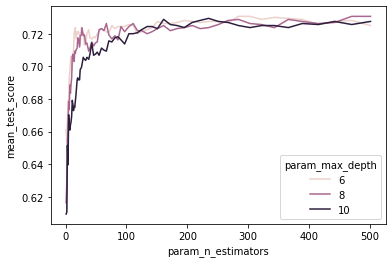

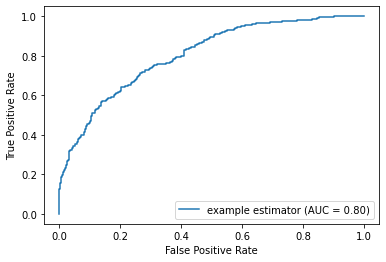

In [6]:
rf_cv_result = pd.DataFrame(grid.cv_results_)
final_rf = grid.best_estimator_

sns.lineplot(x="param_n_estimators", y="mean_test_score", hue="param_max_depth", data=rf_cv_result)
plot_roc_curve(y_test, final_rf.predict_proba(X_test)[:,1])

In [7]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 284}

## XGBoost Classifier

In [6]:
from xgboost import XGBClassifier

In [13]:
RETRAIN = False
xgb_file = "models/xgb_cv.pkl"

if os.path.exists(xgb_file) and not RETRAIN:
    with open(xgb_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")

else:
    xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0, silent=True, random_state=42)
    param_grid = {"n_estimator": (10**np.linspace(1, 2.3, 10)).astype(int),
                  "subsample": [0.6, 0.8],
                  "colsample_bytree": [0.2, 0.4, 0.6, 0.8],
                  "colsample_bylevel": [0.2, 0.4, 0.6, 0.8],
                  "min_child_weight" : [1, 5, 10],
                  "max_depth": [2, 5, 10],}
    grid = GridSearchCV(xgb, param_grid, scoring="accuracy", verbose=3, cv=5, n_jobs=5)
    grid.fit(X_train, y_train)

    with open(xgb_file, "wb") as f:
            pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


In [14]:
xgb_cv_result = pd.DataFrame(grid.cv_results_)
final_xgb = grid.best_estimator_
xgb_cv_result.sort_values("mean_test_score", ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_max_depth,param_min_child_weight,param_n_estimator,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2520,1.352535,0.089413,0.028951,0.019656,0.8,0.6,2,1,10,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
2536,1.329522,0.071857,0.020867,0.015252,0.8,0.6,2,1,143,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
2526,1.331556,0.117477,0.027938,0.020197,0.8,0.6,2,1,27,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
2530,1.336957,0.049013,0.013092,0.008548,0.8,0.6,2,1,52,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
2522,1.387696,0.050808,0.017071,0.008380,0.8,0.6,2,1,13,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,1.020513,0.076780,0.051700,0.069762,0.2,0.4,10,5,52,0.6,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.667712,0.683386,0.683386,0.694969,0.666667,0.679224,0.010703,2871
320,0.970089,0.035494,0.023321,0.006585,0.2,0.4,10,5,10,0.6,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.667712,0.683386,0.683386,0.694969,0.666667,0.679224,0.010703,2871
322,1.047359,0.060078,0.029622,0.019799,0.2,0.4,10,5,13,0.6,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.667712,0.683386,0.683386,0.694969,0.666667,0.679224,0.010703,2871
324,1.127064,0.061868,0.026181,0.010779,0.2,0.4,10,5,19,0.6,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.667712,0.683386,0.683386,0.694969,0.666667,0.679224,0.010703,2871


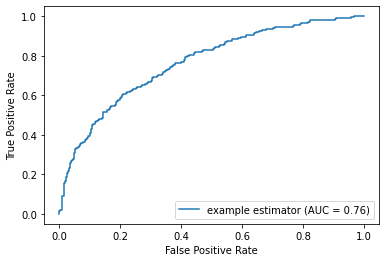

In [12]:
plot_roc_curve(y_test, final_xgb.predict_proba(X_test)[:,1])

<AxesSubplot:xlabel='rank_test_score', ylabel='mean_test_score'>

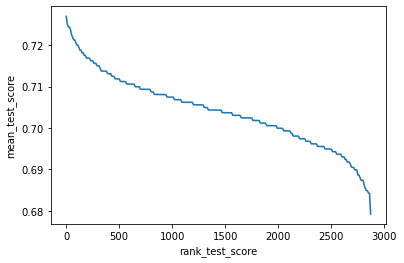

In [16]:
sns.lineplot(x="rank_test_score", y="mean_test_score", data=xgb_cv_result)

## HyperOpt

In [11]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [12]:
def objectives(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params, random_state=42)
    elif classifier_type == 'xgb':
        clf = XGBClassifier(**params, eval_metric="logloss", use_label_encoder=False, random_state=42)
    accuracy = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1).mean()
    return {'loss': -accuracy, 'status': hyperopt.STATUS_OK}

space = hp.choice('clf_type', [
    {
        "type": "rf",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    },
    {
        "type": "xgb",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    }
])

trials = hyperopt.Trials()

best = hyperopt.fmin(objectives, 
                     space, 
                     algo=hyperopt.tpe.suggest, 
                     max_evals=50,
                     trials=trials)

100%|██████████| 50/50 [07:52<00:00,  9.45s/trial, best loss: -0.7187890617298555]


In [13]:
hyperopt.space_eval(space, best)

{'max_depth': 6, 'n_estimators': 437, 'type': 'rf'}